## Library imports

In [1]:
# Step 1: Install the necessary libraries (if not already installed)
!pip install torch torchvision pillow

# Step 2: Import the required packages
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["LC_ALL"] = "C.UTF-8"
os.environ["LANG"] = "C.UTF-8"

## Initial Inference without TensorRT

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


Saving catto.png to catto.png


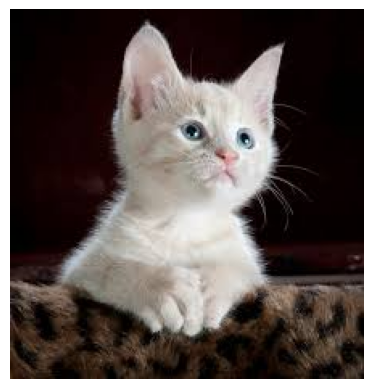

Predicted Class: Egyptian_cat
Predicted Class: 285


In [3]:
# Step 3: Load a pre-trained CNN model (e.g., ResNet18)
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Step 4: Define the preprocessing steps for the image
transform = transforms.Compose([
    transforms.Resize(256),    # Resize the image to 256 pixels on the shorter side
    transforms.CenterCrop(224),  # Crop to the desired size for the model (224x224)
    transforms.ToTensor(),     # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Step 5: Upload an image to Colab (use the upload button in Colab)
from google.colab import files
uploaded = files.upload()

# Get the filename of the uploaded image
filename = list(uploaded.keys())[0]

# Step 6: Open and preprocess the image
image = Image.open(filename).convert('RGB')
plt.imshow(image)  # Display the image
plt.axis('off')
plt.show()

# Apply the transformations
input_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

# Step 7: Perform inference
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)

# Step 8: Load the class labels for ImageNet
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
import json
import urllib.request

with urllib.request.urlopen(LABELS_URL) as url:
    labels = json.loads(url.read().decode())

# Print the predicted class label
print("Predicted Class:", labels[str(predicted_class.item())][1])
print("Predicted Class:", predicted_class.item())


## Export model to ONNX

In [4]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 92.0 MB/s eta 0:00:00


In [5]:
dummy_input = torch.randn(1, 3, 224, 224)  # Change dimensions based on your model's input size
torch.onnx.export(model, dummy_input, "model.onnx", input_names=['input'], output_names=['output'], opset_version=11)

## ONNX to TensorRT

In [6]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.6.0-py2.py3-none-any.whl size=16336 sha256=09eb41fc316b86c00a08dd00271686dc8647d8e9ee08b27d4f7fb952ee2d7160
  Stored in directory: /root/.cache/pip/wheels/2a/97/95/8fdbe17369eed28ee9903523b94e130023ae58edcf1c904e5a
  Created wheel for tensorrt-cu12: filename=tensorrt_cu12-10.6.0-py2.py3-none-any.whl size=17549 sha256=61383d5b3f686e4822f06aba8ea1860b99737d4a7ff9b301e00e074e57284fbb
  Stored in directory: /root/.cache/pip/wheels/78/db/ca/0e81d122890b48aaa016992e062a1eb16dc3d00ac546156517
Successfully built tensorrt tensorrt-cu12


In [16]:
import tensorrt as trt

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(TRT_LOGGER)
config = builder.create_builder_config()
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
parser = trt.OnnxParser(network, TRT_LOGGER)

with open("model.onnx", "rb") as model_file:
    if not parser.parse(model_file.read()):
        for error in range(parser.num_errors):
            print(parser.get_error(error))

# Set memory (4 GiB)
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 32)
config.set_flag(trt.BuilderFlag.FP16)  # Enable FP16 if the hardware supports it

# Build the engine using build_serialized_network
serialized_engine = builder.build_serialized_network(network, config)
# Deserialize the engine
runtime = trt.Runtime(TRT_LOGGER)
engine = runtime.deserialize_cuda_engine(serialized_engine)


## Deploy tensorRT inference

In [8]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=382b4bf7a1c9591922492aec4ac6268c9eaa0fbc7204a6a935b054d967478c45
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [22]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

In [23]:
input_data = input_tensor.to(torch.float32)

context = engine.create_execution_context()

input_binding_name = "input"
input_buffer = cuda.mem_alloc(input_data.nbytes)

output_binding_name = "output"
output_buffer = cuda.mem_alloc(1000 * np.dtype(np.float32).itemsize)

stream = cuda.Stream()

cuda.memcpy_htod(input_buffer, input_data.cpu().numpy())

context.set_tensor_address(input_binding_name, input_buffer)
context.set_tensor_address(output_binding_name, output_buffer)

# Run inference
context.execute_async_v3(stream_handle = stream.handle)
stream.synchronize()

# Transfer output data from the GPU
output_data = np.empty(1000, dtype=np.float32)
cuda.memcpy_dtoh(output_data, output_buffer)

print("Inference output:", output_data)

Inference output: [-1.64453125e+00  6.04980469e-01 -4.75830078e-01 -1.05078125e+00
  8.61328125e-01  1.04589844e+00 -1.39648438e+00 -8.75488281e-01
 -1.37939453e-01  2.33984375e+00 -1.16308594e+00 -3.77929688e+00
 -1.25390625e+00 -2.71875000e+00 -4.99218750e+00 -1.80175781e+00
 -1.12011719e+00 -1.13183594e+00 -2.50195312e+00 -3.68164062e+00
 -9.84375000e-01  1.78515625e+00  1.33984375e+00 -1.69921875e-01
  8.56933594e-02 -2.22656250e+00 -7.34375000e-01 -7.11425781e-01
 -1.64843750e+00  1.01953125e+00 -2.31323242e-01 -2.59570312e+00
 -6.93847656e-01 -2.68750000e+00 -6.53808594e-01 -1.86230469e+00
 -6.61621094e-01 -3.65234375e+00  3.00195312e+00 -5.13183594e-01
 -1.70898438e+00  3.89892578e-01 -1.74218750e+00 -5.98144531e-01
  9.72656250e-01  6.52832031e-01 -1.15332031e+00  3.37890625e-01
 -1.40136719e+00 -1.82128906e+00 -2.45507812e+00  6.72363281e-01
  3.64013672e-01 -1.35742188e+00  2.42773438e+00 -1.24218750e+00
  3.71826172e-01  1.42456055e-01 -5.86853027e-02  7.10449219e-01
  2.945

In [24]:
input_buffer.free()
output_buffer.free()

In [25]:
predicted_class = np.argmax(output_data)
# Print the predicted class
print("Predicted class:", predicted_class)

Predicted class: 285


In [26]:
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
import json
import urllib.request

with urllib.request.urlopen(LABELS_URL) as url:
    labels = json.loads(url.read().decode())

# Print the predicted class label
predicted_class_label = labels[str(predicted_class)][1]
print("Predicted Class:", predicted_class_label)
print("Predicted Class Index:", predicted_class)

Predicted Class: Egyptian_cat
Predicted Class Index: 285
